In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 128
use_gpu = True
y_scale = True
lr = 0.001
weight_decay = 0.0005

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.transform(X_test)
print(X_test.shape)

(60000, 233)
(10000, 233)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [13]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 233])
torch.Size([10000, 233])
torch.Size([42000, 1])


In [15]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [16]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(num_features=512)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(num_features=512)
        
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(num_features=256)
        
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(num_features=128)
        
        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(num_features=64)
        
        self.fc7 = nn.Linear(64, 32)
        self.bn7 = nn.BatchNorm1d(num_features=32)
        
        self.fc8 = nn.Linear(32, 1)
        
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = self.fc8(x)

        return x

In [17]:
model = DNN().to(device)
model.apply(weights_init_uniform)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [18]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    with torch.no_grad():
        pred = model(X)
        
        pred = pred.cpu().numpy()
        if y_scale:
            pred = y_scaler.inverse_transform(pred)            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [ ]:
#train_losses = []
#eval_losses = []
#accs = []
for t in range(5000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 0.0006627655307844417
epochs 1
training loss 0.0006317490471016027
epochs 2
training loss 0.0006569467016458964
epochs 3
training loss 0.0006866859343599268
epochs 4
training loss 0.0007156675273133584
epochs 5
training loss 0.0007092673936575696
epochs 6
training loss 0.0006705386099535802
epochs 7
training loss 0.0006675794273919191
epochs 8
training loss 0.0006678066402886029
epochs 9
training loss 0.0007851188470741117
testing loss 0.0029524533777392026
epochs 10
training loss 0.0006835261828833653
epochs 11
training loss 0.0006856925717072341
epochs 12
training loss 0.0006667661307574927
epochs 13
training loss 0.0006940823072591643
epochs 14
training loss 0.0006745821390496313
epochs 15
training loss 0.0006840340997478825
epochs 16
training loss 0.0006730844584112494
epochs 17
training loss 0.0007093722827125363
epochs 18
training loss 0.0006953587082015085
epochs 19
training loss 0.0006635873911104032
testing loss 0.0028293678802867412
epochs 20
training l

training loss 0.0006587961737291553
epochs 167
training loss 0.0006973628125629051
epochs 168
training loss 0.0006871989662447621
epochs 169
training loss 0.0006550620000393308
testing loss 0.00270166945708123
epochs 170
training loss 0.0006494282337548183
epochs 171
training loss 0.0006705471044682295
epochs 172
training loss 0.0006581643002007247
epochs 173
training loss 0.0006952958005815914
epochs 174
training loss 0.0006649258763615699
epochs 175
training loss 0.0006481247337847823
epochs 176
training loss 0.0007277078170925209
epochs 177
training loss 0.0006558462720163348
epochs 178
training loss 0.0007396973155567699
epochs 179
training loss 0.0007074624721964363
testing loss 0.0025692467366391462
epochs 180
training loss 0.0006671699219897083
epochs 181
training loss 0.0006960838288104156
epochs 182
training loss 0.0006753785363547108
epochs 183
training loss 0.0006540216603542828
epochs 184
training loss 0.0006620841718980856
epochs 185
training loss 0.0006681148018185502
epo

testing loss 0.0027217057121567533
epochs 330
training loss 0.0006770627690078606
epochs 331
training loss 0.0006909668663202425
epochs 332
training loss 0.0006711151567464666
epochs 333
training loss 0.0006795384536149111
epochs 334
training loss 0.0006891282159965315
epochs 335
training loss 0.000709859146449947
epochs 336
training loss 0.0006666245458415486
epochs 337
training loss 0.0006779344510223354
epochs 338
training loss 0.0006527813834578399
epochs 339
training loss 0.0006628257301558194
testing loss 0.002614353318180202
epochs 340
training loss 0.0006832285462362029
epochs 341
training loss 0.0006584495303891939
epochs 342
training loss 0.0006698976088800725
epochs 343
training loss 0.0006724629808772118
epochs 344
training loss 0.0006648973695577142
epochs 345
training loss 0.0006382923187032671
epochs 346
training loss 0.0006615428333092866
epochs 347
training loss 0.0006464934039338687
epochs 348
training loss 0.0006327887723331359
epochs 349
training loss 0.000678220257

training loss 0.0006417802692989685
epochs 493
training loss 0.0006399043555453556
epochs 494
training loss 0.0006630345130739818
epochs 495
training loss 0.0006471223956523151
epochs 496
training loss 0.0006873746387346288
epochs 497
training loss 0.0006537442560885158
epochs 498
training loss 0.000674625974106758
epochs 499
training loss 0.0006477378948703465
testing loss 0.0027321382035197465
epochs 500
training loss 0.0006307331607379812
epochs 501
training loss 0.0006463047159279451
epochs 502
training loss 0.0006383773572650939
epochs 503
training loss 0.0006641803053136926
epochs 504
training loss 0.0006597020966213163
epochs 505
training loss 0.000652445135316118
epochs 506
training loss 0.000644191621525332
epochs 507
training loss 0.0006645734915170128
epochs 508
training loss 0.0006486628804176106
epochs 509
training loss 0.0006647676505122934
testing loss 0.002715586475137925
epochs 510
training loss 0.0006083234150131094
epochs 511
training loss 0.0006856646694492061
epoch

training loss 0.000671428902850325
epochs 656
training loss 0.0006386721317407231
epochs 657
training loss 0.000642235533088038
epochs 658
training loss 0.0006553908904850212
epochs 659
training loss 0.0006427612340737327
testing loss 0.0027054891024108525
epochs 660
training loss 0.0006294184878162791
epochs 661
training loss 0.0006756886958758882
epochs 662
training loss 0.0006554842849423412
epochs 663
training loss 0.0006540813777874589
epochs 664
training loss 0.0006755978139902898
epochs 665
training loss 0.0006418986745620299
epochs 666
training loss 0.0006945145189568208
epochs 667
training loss 0.0006371888066330602
epochs 668
training loss 0.0006414908069358589
epochs 669
training loss 0.0006790286400475706
testing loss 0.0026488263363923536
epochs 670
training loss 0.0006455731562955877
epochs 671
training loss 0.0006504679469555888
epochs 672
training loss 0.0007208902378195732
epochs 673
training loss 0.0006909640590832951
epochs 674
training loss 0.0006216203084952937
epo

training loss 0.0006342914367149836
epochs 819
training loss 0.0006757604454871901
testing loss 0.0044453224292725114
epochs 820
training loss 0.0006386345274686972
epochs 821
training loss 0.0006315672999611662
epochs 822
training loss 0.0006620291104585521
epochs 823
training loss 0.0006494303589536721
epochs 824
training loss 0.0006592945685103468
epochs 825
training loss 0.0006777198771496041
epochs 826
training loss 0.0006028599226790676
epochs 827
training loss 0.000676522593333819
epochs 828
training loss 0.0006528614142146754
epochs 829
training loss 0.0006008271923561873
testing loss 0.0026679472132513284
epochs 830
training loss 0.0006433794763056692
epochs 831
training loss 0.0006661984137483055
epochs 832
training loss 0.0006590041493477532
epochs 833
training loss 0.0006525893338268062
epochs 834
training loss 0.000674483505018214
epochs 835
training loss 0.0006836470641835528
epochs 836
training loss 0.000619194852322691
epochs 837
training loss 0.0006838530343801553
epoc

training loss 0.0006780621343034696
epochs 982
training loss 0.0006675213771924591
epochs 983
training loss 0.0006559255254620511
epochs 984
training loss 0.0006784276639063217
epochs 985
training loss 0.000639053739396442
epochs 986
training loss 0.0006232961262491359
epochs 987
training loss 0.0006621548009676842
epochs 988
training loss 0.0006289913960043227
epochs 989
training loss 0.000625557609760177
testing loss 0.002705127677008351
epochs 990
training loss 0.0006355215784899698
epochs 991
training loss 0.0006130807449203268
epochs 992
training loss 0.0006244202424159223
epochs 993
training loss 0.0006467992691804392
epochs 994
training loss 0.0006476305622436209
epochs 995
training loss 0.0006649001000100877
epochs 996
training loss 0.000671375303944618
epochs 997
training loss 0.0006224886607307952
epochs 998
training loss 0.0006768781798651108
epochs 999
training loss 0.0006181441125740216
testing loss 0.0030085775338225596
epochs 1000
training loss 0.0006179107712421815
epoc

training loss 0.0006348502411405163
epochs 1142
training loss 0.0006603841232150046
epochs 1143
training loss 0.0006638850728729258
epochs 1144
training loss 0.0006646353809451712
epochs 1145
training loss 0.0006442667081694495
epochs 1146
training loss 0.0006342960957163169
epochs 1147
training loss 0.0006187665395652394
epochs 1148
training loss 0.0006500209278659187
epochs 1149
training loss 0.0006384359179758169
testing loss 0.0025337648403365165
epochs 1150
training loss 0.000623390816755757
epochs 1151
training loss 0.0006152595838144037
epochs 1152
training loss 0.0006072278892462875
epochs 1153
training loss 0.0006104919323973686
epochs 1154
training loss 0.000644140993244946
epochs 1155
training loss 0.0006343013286558022
epochs 1156
training loss 0.0006789788328667417
epochs 1157
training loss 0.0006208769317346945
epochs 1158
training loss 0.0006431431748754258
epochs 1159
training loss 0.000616818946969517
testing loss 0.0027171457743648676
epochs 1160
training loss 0.00065

training loss 0.0006579364535659212
epochs 1302
training loss 0.0006329784077616255
epochs 1303
training loss 0.0006210272818574495
epochs 1304
training loss 0.0005993396983238498
epochs 1305
training loss 0.0006200199659968978
epochs 1306
training loss 0.0006276436371581578
epochs 1307
training loss 0.0006703599162384199
epochs 1308
training loss 0.0006765281517231288
epochs 1309
training loss 0.0006374457482521714
testing loss 0.0026845371219369166
epochs 1310
training loss 0.0006508665967175007
epochs 1311
training loss 0.000609280012627939
epochs 1312
training loss 0.000641807201134443
epochs 1313
training loss 0.0006020406177401894
epochs 1314
training loss 0.0006217722955094735
epochs 1315
training loss 0.0006398090042313985
epochs 1316
training loss 0.0006255200102650716
epochs 1317
training loss 0.0006291323350629228
epochs 1318
training loss 0.0006190825859332418
epochs 1319
training loss 0.0006231982122942534
testing loss 0.0026462706235643634
epochs 1320
training loss 0.0006

training loss 0.0006295601830437021
epochs 1462
training loss 0.0006378923674959032
epochs 1463
training loss 0.0006270861274550038
epochs 1464
training loss 0.0006275338951058086
epochs 1465
training loss 0.0006418785452382712
epochs 1466
training loss 0.0006071541937475735
epochs 1467
training loss 0.0006201347861811235
epochs 1468
training loss 0.0006729335194003505
epochs 1469
training loss 0.0005803168732722468
testing loss 0.002607043628607289
epochs 1470
training loss 0.0006795950339382406
epochs 1471
training loss 0.0006332355270114102
epochs 1472
training loss 0.0006473616800924882
epochs 1473
training loss 0.0006442963841688284
epochs 1474
training loss 0.0005950955770475263
epochs 1475
training loss 0.0006527680401034982
epochs 1476
training loss 0.0005873541701882285
epochs 1477
training loss 0.0006753177623374892
epochs 1478
training loss 0.0006260913335838522
epochs 1479
training loss 0.0006308513646626896
testing loss 0.0028450874659622497
epochs 1480
training loss 0.000

training loss 0.0006124522970631255
epochs 1622
training loss 0.0006589004251536967
epochs 1623
training loss 0.0006519839056841123
epochs 1624
training loss 0.0006332318404672447
epochs 1625
training loss 0.0006213279588375874
epochs 1626
training loss 0.0006097053319370051
epochs 1627
training loss 0.0005986285806381593
epochs 1628
training loss 0.00061811098993804
epochs 1629
training loss 0.0006145992681474671
testing loss 0.002764432159325121
epochs 1630
training loss 0.0006486448214465814
epochs 1631
training loss 0.0006453793672462614
epochs 1632
training loss 0.000596258263928125
epochs 1633
training loss 0.0006087789686904841
epochs 1634
training loss 0.0006040554548688743
epochs 1635
training loss 0.0006288391490018216
epochs 1636
training loss 0.0006316047277525181
epochs 1637
training loss 0.000617270514129811
epochs 1638
training loss 0.0006412807306222403
epochs 1639
training loss 0.0006551747127170009
testing loss 0.0026734786455730863
epochs 1640
training loss 0.0006520

training loss 0.0006006043623725242
epochs 1782
training loss 0.0006122567809801153
epochs 1783
training loss 0.0006378549168814868
epochs 1784
training loss 0.0006296707448686861
epochs 1785
training loss 0.0006189672809800467
epochs 1786
training loss 0.0006202096812176521
epochs 1787
training loss 0.0006017788623121361
epochs 1788
training loss 0.0006081391749394021
epochs 1789
training loss 0.0006321582875616486
testing loss 0.0025822856229835633
epochs 1790
training loss 0.000609664441143675
epochs 1791
training loss 0.0006376974035895184
epochs 1792
training loss 0.0006457756757863591
epochs 1793
training loss 0.0006115377033525642
epochs 1794
training loss 0.0006026128359354104
epochs 1795
training loss 0.0005978187587710895
epochs 1796
training loss 0.000620017774275003
epochs 1797
training loss 0.0006463021579754785
epochs 1798
training loss 0.0006456231559686204
epochs 1799
training loss 0.000590058843821774
testing loss 0.0028218245525936866
epochs 1800
training loss 0.00065

training loss 0.0006305280658678296
epochs 1942
training loss 0.0006475422171681927
epochs 1943
training loss 0.0006117335134815696
epochs 1944
training loss 0.0006404569671357667
epochs 1945
training loss 0.0005857005463608775
epochs 1946
training loss 0.0006307761338263421
epochs 1947
training loss 0.0006315456500728431
epochs 1948
training loss 0.0006106779849585598
epochs 1949
training loss 0.0006112697879086025
testing loss 0.0048960092698772115
epochs 1950
training loss 0.0005983589635489617
epochs 1951
training loss 0.000619671074054303
epochs 1952
training loss 0.0006271843747327835
epochs 1953
training loss 0.0006152134344277558
epochs 1954
training loss 0.0006320728275692798
epochs 1955
training loss 0.0006086946764782547
epochs 1956
training loss 0.0005797559583324679
epochs 1957
training loss 0.0006282330608479452
epochs 1958
training loss 0.0006176613855613028
epochs 1959
training loss 0.0005861455188939591
testing loss 0.0039475315782168865
epochs 1960
training loss 0.000

training loss 0.0006021202378587848
epochs 2102
training loss 0.0006445221464739869
epochs 2103
training loss 0.0006019558942781926
epochs 2104
training loss 0.000604082712154173
epochs 2105
training loss 0.0006145153395119647
epochs 2106
training loss 0.0005978491251239423
epochs 2107
training loss 0.0006037619114233504
epochs 2108
training loss 0.000860045353601061
epochs 2109
training loss 0.000683098191594971
testing loss 0.0027205178050525775
epochs 2110
training loss 0.000610413580905012
epochs 2111
training loss 0.000607935635045335
epochs 2112
training loss 0.0005808586371838933
epochs 2113
training loss 0.00061297810782953
epochs 2114
training loss 0.0005996287404948784
epochs 2115
training loss 0.0006068614999746683
epochs 2116
training loss 0.000615430578195255
epochs 2117
training loss 0.0005797842465479799
epochs 2118
training loss 0.0005962785692017888
epochs 2119
training loss 0.0006103774251014357
testing loss 0.0027325606288996045
epochs 2120
training loss 0.0006255770

training loss 0.0005999259409384298
epochs 2262
training loss 0.0006282165915299048
epochs 2263
training loss 0.0006311905647643579
epochs 2264
training loss 0.0005954582711057539
epochs 2265
training loss 0.0006264317004925834
epochs 2266
training loss 0.0006164969683739451
epochs 2267
training loss 0.0006113304512604992
epochs 2268
training loss 0.0006067197253972881
epochs 2269
training loss 0.0005955797358094729
testing loss 0.002732035447595681
epochs 2270
training loss 0.0005447467235992677
epochs 2271
training loss 0.0005923072083168139
epochs 2272
training loss 0.0006305189400919824
epochs 2273
training loss 0.0006034182740933061
epochs 2274
training loss 0.0007999858340017758
epochs 2275
training loss 0.0006592184454514037
epochs 2276
training loss 0.0006253784276491263
epochs 2277
training loss 0.0006234929291814521
epochs 2278
training loss 0.0006054458252612875
epochs 2279
training loss 0.0006026603014521176
testing loss 0.0027325641609900067
epochs 2280
training loss 0.000

training loss 0.0006195006701539025
epochs 2422
training loss 0.0006108074913425569
epochs 2423
training loss 0.000625001012714223
epochs 2424
training loss 0.0005557035763166267
epochs 2425
training loss 0.0006023891250522224
epochs 2426
training loss 0.0006044685242076243
epochs 2427
training loss 0.000557721698728155
epochs 2428
training loss 0.0005982715673114833
epochs 2429
training loss 0.0006178911993142761
testing loss 0.002642167044773777
epochs 2430
training loss 0.000608340447123154
epochs 2431
training loss 0.0006539627902937266
epochs 2432
training loss 0.0006086504255636598
epochs 2433
training loss 0.0005933951532877246
epochs 2434
training loss 0.0005974264248057713
epochs 2435
training loss 0.0006621829213717482
epochs 2436
training loss 0.0006185033626494912
epochs 2437
training loss 0.0006357303726427416
epochs 2438
training loss 0.0005580608389413941
epochs 2439
training loss 0.0005894881432718884
testing loss 0.0026954544810512174
epochs 2440
training loss 0.000597

training loss 0.0005692346345302069
epochs 2582
training loss 0.000607957587383495
epochs 2583
training loss 0.0005862587807405638
epochs 2584
training loss 0.0005819484668268644
epochs 2585
training loss 0.0006189263343675159
epochs 2586
training loss 0.0006000044294576356
epochs 2587
training loss 0.0006061631049975006
epochs 2588
training loss 0.0005566403874844358
epochs 2589
training loss 0.0005723775193197115
testing loss 0.002653231356352409
epochs 2590
training loss 0.0006072965779130865
epochs 2591
training loss 0.000583797669367961
epochs 2592
training loss 0.000580683081020887
epochs 2593
training loss 0.0005892389088601587
epochs 2594
training loss 0.0005753992677745509
epochs 2595
training loss 0.0005785907019109474
epochs 2596
training loss 0.0005843055044940608
epochs 2597
training loss 0.0006012676500801654
epochs 2598
training loss 0.0005864806343747535
epochs 2599
training loss 0.000611875654554906
testing loss 0.0033715458352330096
epochs 2600
training loss 0.0006278

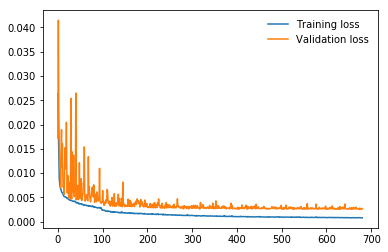

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)

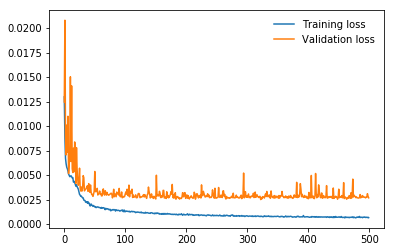

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


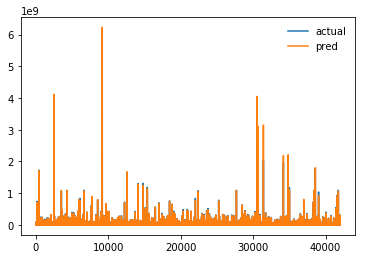

In [21]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [22]:
pred = test_func(model, X_test)


In [23]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.545144e+07
1,BTshNOJyKHnT2YIT,4.040076e+06
2,dhdymr0lV8N5kZOT,1.083878e+07
3,VEwyGGMcD56w5BOc,6.272110e+06
4,wmUeMoJZfsqaSX9b,2.701183e+06
5,EtBjGAHmHCe9t7TZ,3.687719e+06
6,hPNH34vmaZtvBtqc,1.539422e+07
7,wXjeI38bYDMJJwZC,7.480202e+06
8,fxZSGX6aPAFKU8W4,2.701183e+06
9,ewr0Fx6ign87OwaV,6.056791e+06


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512

Result 2 lr=0.001, batch_size=64, DNN 233->256->128->64->1
after 1k loss : 0.00011785521522113447, can't decrease...
- x_scale false
- y_scale true

Result 3 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->1
after 1w loss : 0.0003, test loss : 0.0007 score: 1670

Result 4 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1
train_loss: 0.0004, test loss: 0.0002 score: 1600

Result 5 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
train_loss: 0.0005, test loss: 0.003 score: 1000

Result 6 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->1 + batch_noram + weight_decay
after 2k
train_loss: 0.004, test loss 0.006 ,look like L2 regular not work which will increase loss

Result 6 lr=0.0015 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
after 3k
train_loss 0.0004 test loss 0.002 score : 1400
I think we should reduce lr or add L2 regularzation

Result 7 lr=0.0015 batch_size= 128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram + weight_decay(0.0005)
after 3.5k 
train loss 0.0007, test loss 0.002, score: 2217
regularzation is work, but test loss is not reduce, next tuning lr



### question

why output is negative?